In [9]:
import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
import sys
import os

import pandas as pd
import csv

# import audio_decryption
import librosa
import IPython.display
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
path_project = '/beegfs/yw3004/projects/ismir2018_LBD/'

# 1. Load data

In [11]:
X_val = pickle.load(open(os.path.join(path_project + 'X_val.pickle'), "rb" ))
y_val = pickle.load(open(os.path.join(path_project + 'y_val.pickle'), "rb" ))
X_test = pickle.load(open(os.path.join(path_project + 'X_test.pickle'), "rb" ))
y_test = pickle.load(open(os.path.join(path_project + 'y_test.pickle'), "rb" ))
X_pool = pickle.load(open(os.path.join(path_project + 'X_pool.pickle'), "rb" ))
key_pool = pickle.load(open(os.path.join(path_project + 'key_pool.pickle'), "rb" ))

# 2. Predicted score distribution #

In [12]:
def pred_score_dist(model_path):
    model = pickle.load(open(model_path, "rb" ))

    pred_prob = model.predict_proba(X_val)
    y_val_array = y_val.reshape(-1,1)
    score_dist = np.concatenate((pred_prob, y_val_array),axis=1)
    
    true_pos_scores = []
    true_neg_scores = []
    for score in score_dist:
        if score[2] == 1:
            true_pos_scores.append(score[1])
        else:
            true_neg_scores.append(score[1])
    plt.hist(true_pos_scores,100, alpha=0.5, edgecolor='k', label='true positives')
    plt.hist(true_neg_scores,100, alpha=0.5, edgecolor='k', label='true negatives')
    plt.legend(loc='best', fontsize=15)
    plt.xlabel('Predicted probability of being positive', fontsize=15)
    plt.ylabel('Counts', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0,1)
    plt.show()

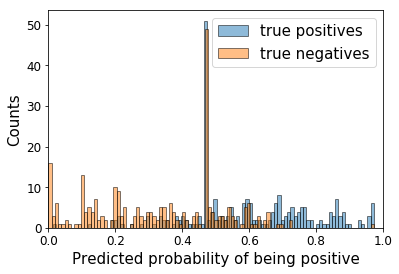

In [13]:
pred_score_dist(os.path.join(path_project, 'models', 'model_initial.pickle'))

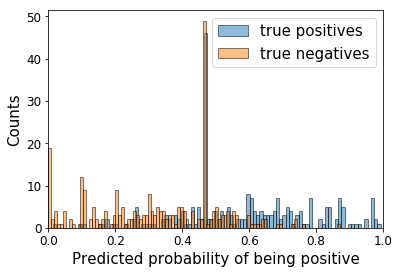

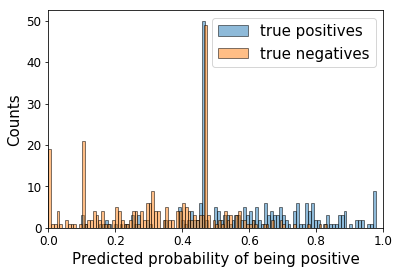

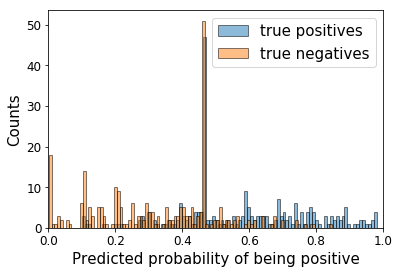

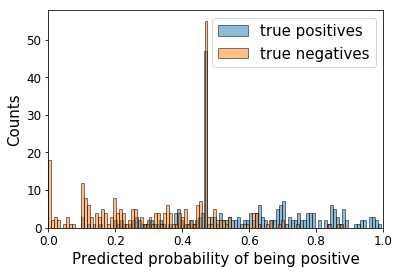

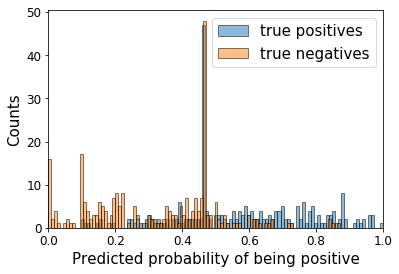

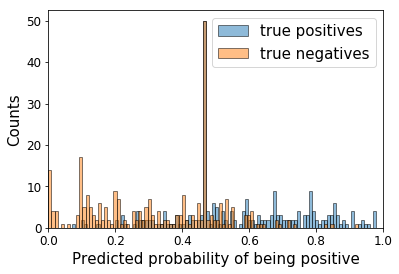

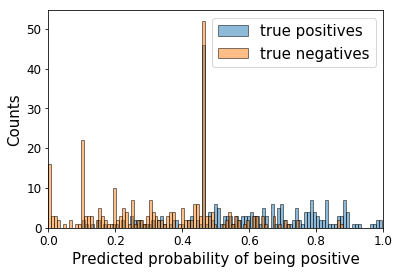

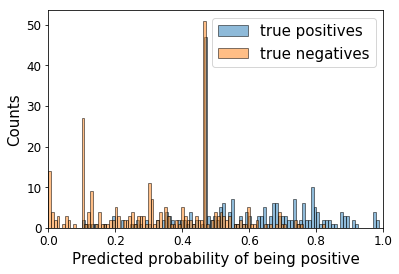

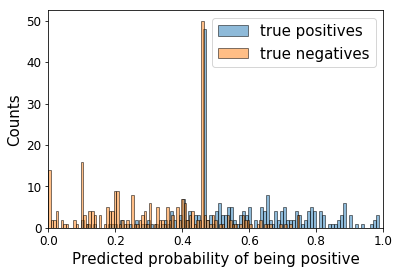

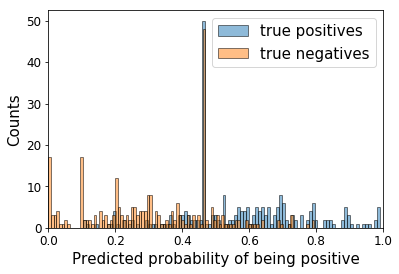

In [14]:
for i in range(1,11):
    model_path = os.path.join(path_project, 'models', 'model_iter_'+str(i)+'.pickle')
    pred_score_dist(model_path)

## Need modification

In [118]:
pos_in, neg_in = pred_score_dist('/scratch/yw3004/sonyc/sonyc_distortion_classification/models/model_initial.pickle')
pos_2, neg_2 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(2)+'.pickle'))
pos_10, neg_10 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(10)+'.pickle'))
pos_20, neg_20 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(20)+'.pickle'))
pos_50, neg_50 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(50)+'.pickle'))
pos_100, neg_100 = pred_score_dist(os.path.join(model_floder+'model_2_iter_'+str(100)+'.pickle'))

Text(0.5,1,'100 iterations')

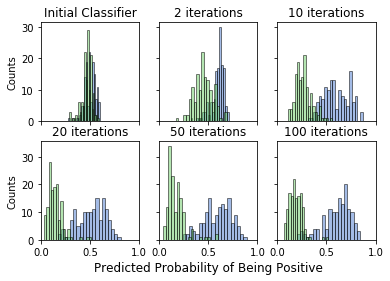

In [127]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
ax1.hist(pos_in,20, alpha=0.5, edgecolor='k', label='true positives')
ax1.hist(neg_in,20, alpha=0.5, edgecolor='k', label='true positives')
ax1.set_title('Initial Classifier')
ax1.set_ylabel('Counts')
ax1.set_xlim(0,1)
ax2.hist(pos_2,20, alpha=0.5, edgecolor='k', label='true positives')
ax2.hist(neg_2,20, alpha=0.5, edgecolor='k', label='true positives')
ax2.set_title('2 iterations')
ax2.set_xlim(0,1)
ax3.hist(pos_10,20, alpha=0.5, edgecolor='k', label='true positives')
ax3.hist(neg_10,20, alpha=0.5, edgecolor='k', label='true positives')
ax3.set_title('10 iterations')
ax3.set_xlim(0,1)
ax4.hist(pos_20,20, alpha=0.5, edgecolor='k', label='true positives')
ax4.hist(neg_20,20, alpha=0.5, edgecolor='k', label='true positives')
ax4.set_title('20 iterations')
ax4.set_ylabel('Counts')
ax5.hist(pos_50,20, alpha=0.5, edgecolor='k', label='true positives')
ax5.hist(neg_50,20, alpha=0.5, edgecolor='k', label='true positives')
ax5.set_title('50 iterations')
ax5.set_xlabel('Predicted Probability of Being Positive', fontsize=12)
ax6.hist(pos_100,20, alpha=0.5, edgecolor='k', label='true positives')
ax6.hist(neg_100,20, alpha=0.5, edgecolor='k', label='true positives')
ax6.set_title('100 iterations')
# plt.tight_layout()

# 3. F-measure (on val data) at each iteration #

In [17]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [18]:
def get_fmeasure_threshold(model, thresholds):
    fmeasures = []
    for threshold in thresholds:
        pred_proba = model.predict_proba(X_val)
        pred = adjusted_classes(pred_proba[:,1], threshold)
        pred = np.array(pred)
        fmeasures.append(f1_score(y_val, pred))
    
    fmeasure_best = max(fmeasures)
    threshold_best = thresholds[np.argmax(fmeasures)]
    return fmeasure_best, threshold_best

In [20]:
model_folder = os.path.join(path_project, 'models')
thresholds = np.arange(0.1,0.9,0.01)
fmeasure_bests = []
threshold_bests = []
model_initial = pickle.load(open(os.path.join(model_folder,'model_initial'+'.pickle'), "rb" ))
fmeasure_best_initial, threshold_best_initial = get_fmeasure_threshold(model_initial, thresholds)
fmeasure_bests.append(fmeasure_best_initial)
threshold_bests.append(threshold_best_initial)  
                                              
for i in range(1,11):
    model = pickle.load(open(os.path.join(model_folder,'model_iter_'+str(i)+'.pickle'), "rb" ))
    fmeasure_best, threshold_best = get_fmeasure_threshold(model, thresholds)
    fmeasure_bests.append(fmeasure_best)
    threshold_bests.append(threshold_best)

Text(0.5,0,'Training iterations')

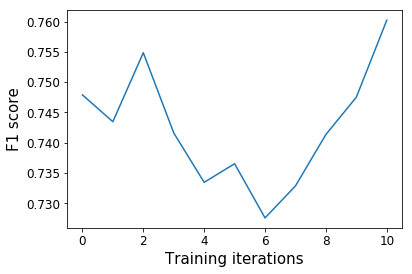

In [21]:
plt.plot(fmeasure_bests[:11])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('F1 score', fontsize=15)
plt.xlabel('Training iterations', fontsize=15)

In [22]:
best_fmeasure = max(fmeasure_bests)
best_iter = np.argmax(fmeasure_bests)
best_threshold = threshold_bests[best_iter]
print(best_fmeasure)
print(best_threshold)
print(best_iter)

0.7602131438721136
0.3999999999999998
10


# 4. Load best model#

In [23]:
best_model = pickle.load(open(os.path.join(model_folder,'model_iter_10.pickle'), "rb" ))

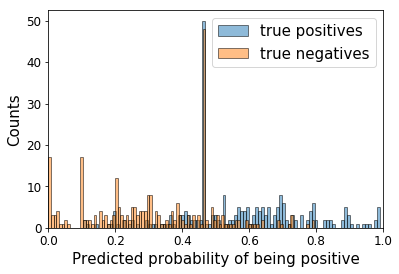

In [24]:
pred_score_dist(os.path.join(model_folder,'model_iter_10.pickle'))

## Val precision/recal

In [25]:
val_pred_prob = best_model.predict_proba(X_val)
val_pred = adjusted_classes(val_pred_prob[:,1], 0.4)
val_precision = precision_score(y_val, val_pred)
val_recall = recall_score(y_val, val_pred)
val_confusion_matrices = confusion_matrix(y_val, val_pred)
print(val_precision)
print(val_recall)
print(val_confusion_matrices)

0.6772151898734177
0.8663967611336032
[[171 102]
 [ 33 214]]


## Test prediction distribution, precision/recall

In [26]:
test_pred_prob = best_model.predict_proba(X_test)
# test_pred_prob = model_random.predict_proba(x_test)
y_test_ = y_test.reshape(-1,1)
test_score_dist = np.concatenate((test_pred_prob, y_test_),axis=1)

In [27]:
true_pos_scores = []
true_neg_scores = []
for score in test_score_dist:
    if score[2] == 1:
        true_pos_scores.append(score[1])
    else:
        true_neg_scores.append(score[1])

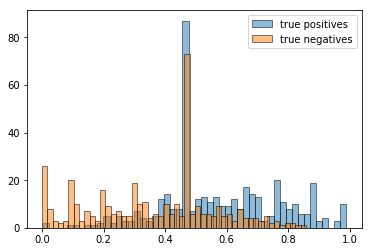

In [28]:
plt.hist(true_pos_scores,50, alpha=0.5, edgecolor='k', label='true positives')
plt.hist(true_neg_scores,50, alpha=0.5, edgecolor='k', label='true negatives')
plt.legend(loc='best')

In [29]:
test_pred = adjusted_classes(test_pred_prob[:,1], 0.32)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_confusion_matrices = confusion_matrix(y_test, test_pred)
print(test_precision)
print(test_recall)
print(test_confusion_matrices)

0.6292682926829268
0.9214285714285714
[[164 228]
 [ 33 387]]


# 5. Get misclassified samples

In [31]:
def load_misclassified(model, X_test, y_test, threshold):
    test_pred_prob = model.predict_proba(X_test)
    test_pred = adjusted_classes(test_pred_prob[:,1], threshold)
    misclassified = np.where(y_test != test_pred)[0]
    for idx in misclassified:
        print(test_pred_prob[idx])
        print(y_test[idx])
        key = key_pool[query_idx[i]][0]
        filepath = os.path.join(path_project, 'fma-audio', str(key) +'.ogg')
        y_track, sr = librosa.core.load(filepath)
        IPython.display.display(IPython.display.Audio(data=y_track, rate=sr))

In [303]:
load_misclassified(best_model, x_test, y_test, 0.4)

## Need modification

# 6. Draw random training data for comparison #

In [304]:
idx = list(range(0,X_pool.shape[0]))
random.shuffle(idx)
idx = idx[:10]
X_train = np.zeros((10,256))
y_train = np.zeros((10,1))
for i in range(len(idx)):
    X_train[i] = X_pool[idx[i]]
    key = key_pool[query_idx[i]][0]
    filepath = os.path.join(path_project, 'fma-audio', str(key) +'.ogg')
            
    y_track, sr = librosa.core.load(filepath)
    IPython.display.display(IPython.display.Audio(data=y_track, rate=sr))
             
    label = input("Please input label for\nsample_key = '%s' (1 if saxophone is present, 0 if saxophone is not present)" % (key))
    y_train[i] = (int(label))

In [32]:
X_train.shape

In [141]:
y_train.shape
y_train = np.ravel(y_train)

In [142]:
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
with open(os.path.join(model_folder, 'model_random.pickle'), 'wb') as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

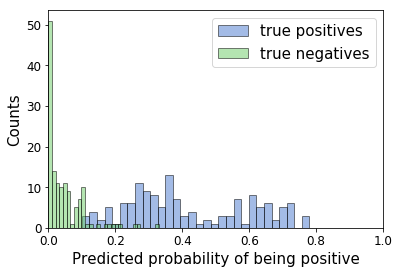

In [180]:
pred_score_dist(os.path.join(model_folder, 'model_random.pickle'))

In [149]:
model_random = pickle.load(open(os.path.join(model_folder, 'model_random.pickle'), "rb" ))

In [150]:
thresholds = np.arange(0.1,0.9,0.01)
f,t = get_fmeasure_threshold(model_random, thresholds)

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
t

0.20999999999999996

## Tune hyper parameters of random forest classifier

In [305]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, 200],
    'max_features': [2, 4, 16,64,128],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [100, 300, 500, 1000]
}
# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_test, y_test)
grid_search.best_params_